# CitizenWatt - Calcul des données affichées

Ce document explique en des termes simples les opérations effectuées sur les données recueillies par les capteurs de [CitizenWatt](http://www.citizenwatt.paris/) afin d'être affichées.

## Données initiales

Le capteur envoie une mesure de puissance en watts (W) toutes les $T_0 = 8s$.

Cette période n'est pas exacte, il faut donc prendre en compte de petites variations autour et ne pas reposer sur un délais parfait.

D'autre part, la communication entre le capteur et la base effectuant les calculs étant sans fil, il n'est pas impossible de perdre quelques mesures ponctuellement.

Enfin, le capteur fonctionne sur piles et il peut donc y avoir des plages longues sans données, entre la fin des piles et leur remplacement.

## Objectifs

L'affichage se fait en kilowatts-heure (kWh) ou en euros (€) et il faut donc convertir ces données. La conversion en euros nécessite la prise en compte de la distinction entre tarif de jour et tarif de nuit.

D'autre part, l'instabilité des mesures nécessite à la fois de masquer les petits manques de mesure, mais également de signaler les manques à long terme.

*Note: Cette conversion s'effectue dans [le code de la base](https://github.com/CitoyensCapteurs/CitizenWatt-Base) dans la fonction `libcitizenwatt.tools.energy`.*

## Conversion en kilowatts-heure

L'idée de base est de faire une simple intégration :

$$E (\text{en kWh}) = \int P (\text{en kW}) dt (\text{en h})$$

Notez déjà les unités : pour avoir des kilowatts-heure (kWh), il faut des temps en heures (h) et des mesures en kilowatts (kW).

$$t (\text{en h}) = t (\text{en s}) / 3600$$

$$P (\text{en kW}) = P (\text{en W}) / 1000$$

Pour ce qui est de trouver $P$, tout dépend de la méthode d'intégration. Je ne vais pas entrer dans les détails, il existe un certain nombre de méthodes dont le degré de difficulté mathématique est très variable puisque nous utilisons pour le moment la plus simple.


On connaît la valeur de $P$ tous les $T_0$, lorsque le capteur nous donne une mesure, mais pour intégrer, il faut connaître toutes les données. Le plus simple est alors de considérer que la puissance reste à peu près la même entre les deux mesures :

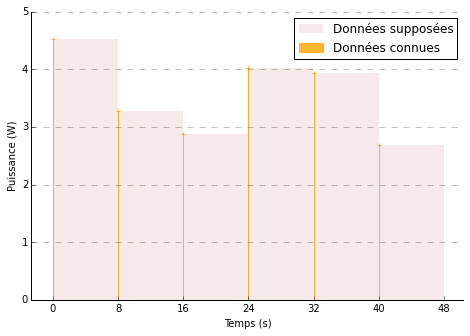

In [9]:
figure1()

On peut également envisager d'utiliser la méthode des trapèzes, qui n'est pas beaucoup plus compliquée et plus précise, mais dont le principal inconvénient est qu'elles nécessite de connaître la valeur suivante. On conserve donc la méthode précédente (en escaliers) pour la dernière mesure :

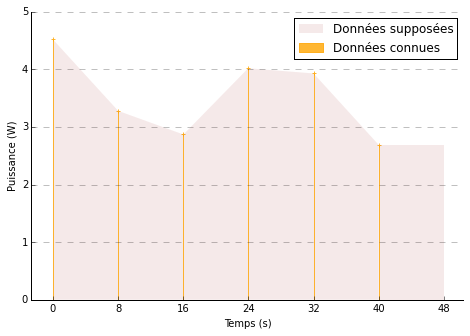

In [10]:
figure2()

## Conversion en euros

Pour un tarif donné, la conversion en euros pour un mois complet est affine en l'énergie $E$ consommée :

$$F_{\text{mois}} (\text{en €}) = \alpha \cdot E_{\text{mois}} (\text{en kWh}) + \beta$$

Les constantes de tarif $\alpha$ et $\beta$ sont données par le type d'abonnement de l'utilisateur.

Afin de rapporter cette relation à une période $T$ différente du mois, la constante $\beta$ est corrigée linéairement :

$$\beta_T = \beta_{\text{mois}} \cdot \frac{T}{\text{1 mois}}$$

On obtient donc, de façon plus générale :

$$F_T (\text{en €}) = \alpha \cdot E_T (\text{en kWh}) + \beta \cdot \frac T {\text{1 mois}}$$

On assure ainsi l'application d'une relation de Chasles aux prix affichés :

$$F_{AB} = F_A + F_B$$

## Gestion des données manquantes

### Problème

Une donnée peut manquer dans deux situations :

1. Un problème de communication temporaire fait perdre une ou plusieurs mesures. Nous avons fait le choix de ne corriger que s'il manque une valeur, car bien que l'on ne veuille pas que le graphe de l'utilisateur soit plein de données manquantes, on ne veut pas non plus lui donner l'illusion que des données sont présentes si ce n'est pas le cas.

2. Les incertitudes sur la période de 8 s font que la tranche d'exactement 8 s qu'une requête demande ne contient aucune données. C'est moins improbable qu'on ne peut le penser au premier abord. Par exemple, si des données sont arrivées à $t=15.98s$ puis à $t=24.02$ et que l'on demande la consomation entre $t=16$ et $t=24$ pour dessiner l'une des barres du graphe, aucune donnée ne sera disponible. (voir Figure 3)

Sur la durée de vie d'un capteur, l'écart entre son horloge et celle de la base est bien réelle et on ne peut donc pas assurer qu'il suffit pour éviter le second point de prendre des valeurs entre $8n-4$ secondes et $8n+4$ secondes et supposer que toutes les mesures sont autour de $8n$ secondes.

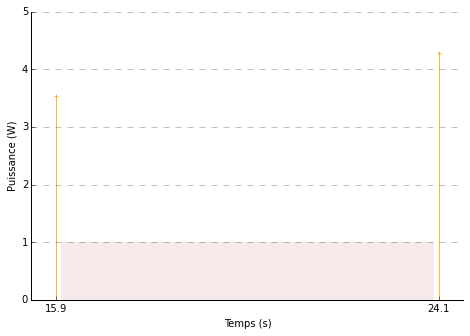

In [11]:
figure3()

### Solution adoptée

Lorsqu'une mesure manque en milieu de bloc sur lequel on intègre les données, elle est remplacée par la moyenne des deux valeurs voisines. Cela nécessite donc qu'il y ait une valeur avant et après.

*Note : Pour le cas de la méthode des trapèze, ça ne change pas la valeur de l'intégrale par rapport au cas où l'on omet de reconstruire la valeur manquante.*

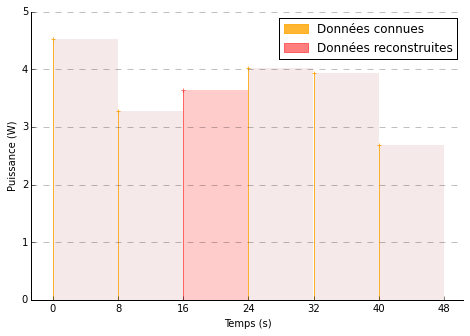

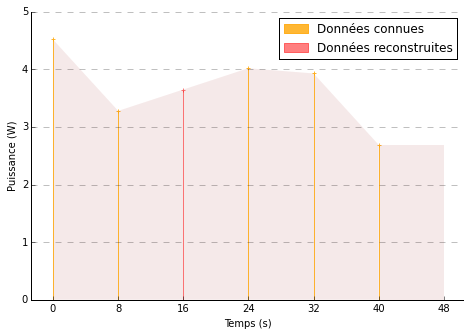

In [12]:
figure4()
figure5()

Dans le cas de mesure manquante en limite, et en fait plus généralement au niveau des bornes d'intégration, une mesure au niveau de la borne est reconstruite :

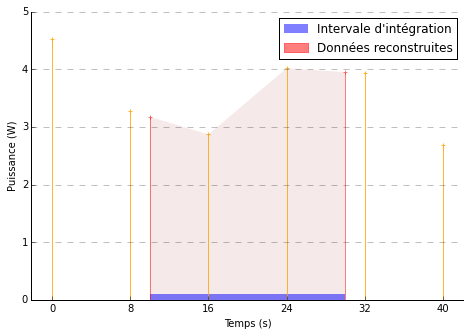

In [13]:
figure6()

## Annexe : Construction des figures

Cette partie doit être exécutée avant le reste du document afin de définir les différentes figures.

In [1]:
%matplotlib inline
from matplotlib.pyplot import figure
from matplotlib.patches import Polygon
import numpy as np

In [2]:
# Prenons quelques mesures d'exemple
times    = [0.00, 8.01, 16.02, 23.97, 32.00, 39.99]
measures = [4.52, 3.28, 2.87,  4.02,  3.93,  2.69 ]

In [3]:
def figure1():
    plot = figure().add_axes([0, 0, 1, 1])
    plot.set_ylim([0, 5])
    plot.spines['right'].set_color('none')
    plot.spines['top'].set_color('none')
    plot.yaxis.tick_left()
    plot.xaxis.tick_bottom()
    plot.grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5, axis='y')
    plot.set_xlabel('Temps (s)')
    plot.set_ylabel('Puissance (W)')
    plot.set_xticks([0, 8, 16, 24, 32, 40, 48])

    plot.scatter(times, measures, marker='+', color='orange', alpha=0.8)
    plot.bar(times, measures, width=8, linewidth=0, color='brown', alpha=0.1, label='Données supposées')
    plot.bar(times, measures, width=0, edgecolor='orange', color='orange', alpha=0.8, label='Données connues')
    plot.legend(loc=1)
    
    return

In [4]:
def figure2():
    plot = figure().add_axes([0, 0, 1, 1])
    plot.set_ylim([0, 5])
    plot.spines['right'].set_color('none')
    plot.spines['top'].set_color('none')
    plot.yaxis.tick_left()
    plot.xaxis.tick_bottom()
    plot.grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5, axis='y')
    plot.set_xlabel('Temps (s)')
    plot.set_ylabel('Puissance (W)')
    plot.set_xticks([0, 8, 16, 24, 32, 40, 48])

    plot.scatter(times, measures, marker='+', color='orange', alpha=0.8)
    verts = [(times[0], 0)] + list(zip(times, measures)) + [(times[-1], 0)]
    poly = Polygon(verts, facecolor='brown', alpha=0.1, linewidth=0, label='Données supposées')
    plot.add_patch(poly)
    plot.bar(times[-1], measures[-1], width=8, linewidth=0, color='brown', alpha=0.1)
    plot.bar(times, measures, width=0, edgecolor='orange', color='orange', alpha=0.8, label='Données connues')
    plot.legend(loc=1)
    
    return

In [5]:
def figure3():
    times = [15.9, 24.1]
    measures = [3.54, 4.28]
    
    plot = figure().add_axes([0, 0, 1, 1])
    plot.set_ylim([0, 5])
    plot.spines['right'].set_color('none')
    plot.spines['top'].set_color('none')
    plot.yaxis.tick_left()
    plot.xaxis.tick_bottom()
    plot.grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5, axis='y')
    plot.set_xlabel('Temps (s)')
    plot.set_ylabel('Puissance (W)')
    plot.set_xticks(times)

    plot.scatter(times, measures, marker='+', color='orange', alpha=0.8)
    plot.bar([16], [1], width=8, linewidth=0, color='brown', alpha=0.1)
    plot.bar(times, measures, width=0, edgecolor='orange', color='orange', alpha=0.8)
    
    return

In [6]:
def figure4():
    global times, measures
    times2 = times.copy()
    measures2 = measures.copy()
    del times2[2]
    del measures2[2]
    
    plot = figure().add_axes([0, 0, 1, 1])
    plot.set_ylim([0, 5])
    plot.spines['right'].set_color('none')
    plot.spines['top'].set_color('none')
    plot.yaxis.tick_left()
    plot.xaxis.tick_bottom()
    plot.grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5, axis='y')
    plot.set_xlabel('Temps (s)')
    plot.set_ylabel('Puissance (W)')
    plot.set_xticks([0, 8, 16, 24, 32, 40, 48])

    plot.bar(times2, measures2, width=8, linewidth=0, color='brown', alpha=0.1)
    
    plot.scatter(times2, measures2, marker='+', color='orange', alpha=0.8)
    plot.bar(times2, measures2, width=0, edgecolor='orange', color='orange', alpha=0.8, label='Données connues')
    
    plot.scatter((times2[1] + times2[2]) / 2, (measures2[1] + measures2[2]) / 2, marker='+', color='red', alpha=0.5)
    plot.bar((times2[1] + times2[2]) / 2, (measures2[1] + measures2[2]) / 2, width=0, edgecolor='red', color='red', alpha=0.5, label='Données reconstruites')
    plot.bar((times2[1] + times2[2]) / 2, (measures2[1] + measures2[2]) / 2, width=8, linewidth=0, color='red', alpha=0.2)
    
    plot.legend(loc=1)
    
    return

In [7]:
def figure5():
    global times, measures
    times2 = times.copy()
    measures2 = measures.copy()
    del times2[2]
    del measures2[2]
    
    plot = figure().add_axes([0, 0, 1, 1])
    plot.set_ylim([0, 5])
    plot.spines['right'].set_color('none')
    plot.spines['top'].set_color('none')
    plot.yaxis.tick_left()
    plot.xaxis.tick_bottom()
    plot.grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5, axis='y')
    plot.set_xlabel('Temps (s)')
    plot.set_ylabel('Puissance (W)')
    plot.set_xticks([0, 8, 16, 24, 32, 40, 48])

    verts = [(times2[0], 0)] + list(zip(times2, measures2)) + [(times2[-1], 0)]
    poly = Polygon(verts, facecolor='brown', alpha=0.1, linewidth=0)
    plot.add_patch(poly)
    plot.bar(times2[-1], measures2[-1], width=8, linewidth=0, color='brown', alpha=0.1)
    
    plot.scatter(times2, measures2, marker='+', color='orange', alpha=0.8)
    plot.bar(times2, measures2, width=0, edgecolor='orange', color='orange', alpha=0.8, label='Données connues')
    
    plot.scatter((times2[1] + times2[2]) / 2, (measures2[1] + measures2[2]) / 2, marker='+', color='red', alpha=0.5)
    plot.bar((times2[1] + times2[2]) / 2, (measures2[1] + measures2[2]) / 2, width=0, edgecolor='red', color='red', alpha=0.5, label='Données reconstruites')
    
    plot.legend(loc=1)
    
    return

In [8]:
def figure6():
    times = np.arange(len(measures)) * 8
    
    a, b = 10, 30 # Bornes d'intégration
    
    plot = figure().add_axes([0, 0, 1, 1])
    plot.set_ylim([0, 5])
    plot.spines['right'].set_color('none')
    plot.spines['top'].set_color('none')
    plot.yaxis.tick_left()
    plot.xaxis.tick_bottom()
    plot.grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5, axis='y')
    plot.set_xlabel('Temps (s)')
    plot.set_ylabel('Puissance (W)')
    plot.set_xticks(times)

    t_a = (a - times[1]) / (times[2] - times[1])
    m_a = measures[1] * (1 - t_a) + measures[2] * t_a
    
    t_b = (b - times[3]) / (times[4] - times[3])
    m_b = measures[3] * (1 - t_b) + measures[4] * t_b
    
    verts = [(a, 0), (a, m_a)] + list(zip(times[2:4], measures[2:4])) + [(b, m_b), (b, 0)]
    poly = Polygon(verts, facecolor='brown', alpha=0.1, linewidth=0)
    plot.add_patch(poly)
    
    plot.bar([a], [0.1], width=b - a, linewidth=0, color='blue', alpha=0.5, label='Intervale d\'intégration')
    
    plot.scatter(times, measures, marker='+', color='orange', alpha=0.8)
    plot.bar(times, measures, width=0, edgecolor='orange', color='orange', alpha=0.8)
    
    plot.scatter([a, b], [m_a, m_b], marker='+', color='red', alpha=0.5)
    plot.bar([a, b], [m_a, m_b], width=0, edgecolor='red', color='red', alpha=0.5, label='Données reconstruites')
    
    plot.legend(loc=1)
    
    return